# OFC 2024 Hack Your Research
# **XLRON** for &#x1f525;_blazingly fast_&#x1f525; RL on optical networks problems! 

### What are we going to do today?
#### 0. Learn how XLRON can help accelerate your research
#### 1. Setup a virtual environment to start experiencing &#x1f3ce; _the speed_ &#x1f3ce;
#### 2. JAX and functional programming fundamentals &#x2699;
#### 3. Let's talk about data structures &#x1f916;
#### 4. A simple reinforcement learning loop &#x267b;
#### 5. BRING ON THE GPU POWER &#x1f4a5;
#### 6. Evaluation and plotting &#x1f4c8;
#### BONUS: Experiment tracking with Weights and Biases &#x1f4d6;

## FIRST THINGS FIRST
### What's an XLRON?
XLRON (“ex-el-er-on”) (“**X**”-elerated **L**earning and **R**esource Allocation for **O**ptical **N**etworks) is a Python library for fast and scalable reinforcement learning on optical networks. It is built on top of JAX, a library for composable function transformations and efficient GPU/TPU computing. XLRON is designed to be easy to use, and to train on lots of parallel environments to achieve high throughput. It is also designed to be easy to extend, so that researchers can experiment with new algorithms and architectures.

### What good is it?
XLRON gives a massive boost to the speed at which you can train reinforcement learning agents on optical networks problems. This allows rapid experimentation, 

### How does it do it?
- Massive parallelization on accelerator hardware
- Speedup from JIT compilation
- Avoid CPU-GPU data transfer bottleneck
- Avoid Python interpreter overhead



<img src="../docs/images/xlron_diagram.png"  width="1200">




# 1. Let's install the required packages

In [ ]:
# set up virtual environment
!pip install virtualenv
!virtualenv venv
!source venv/bin/activate
# install required packages
!pip install -r https://raw.githubusercontent.com/micdoh/XLRON/main/requirements.txt

In [ ]:
## N.B. if you're running this notebook on a GPU machine, you can install the GPU version of JAX by running the following command (or substitute cuda12 for cuda11 depending on your CUDA version):
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

___

# 2. JAX and functional programming

### What's JAX?
JAX is a library for numerical computing that lets you write high-performance, vectorized code that runs on GPU, TPU, and CPU. It is a composable function transformation library designed for high performance numerical computing and large-scale machine learning.


In [1]:
# Let's import jax and see what devices we have access to
import jax
import jax.numpy as jnp

print(jax.devices())

[cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]




### What's functional programming?
Functional programming requires all functions to be pure (i.e. have no "side effects"; they give the same output for the same input every time), and a program is expressed as a composition of these transformation functions.

In [2]:
import jax
import jax.numpy as jnp

def impure_print_side_effect(x):
  print("Executing function")  # This is a side-effect
  return x

# The side-effects appear during the first run
print("First call: ", jax.jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print("Second call: ", jax.jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print("Third call, different type: ", jax.jit(impure_print_side_effect)(jnp.array([5.])))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


Explaining all the intricacies of JAX and functional programming is beyond the scope of this notebook, but you can find more information in the [JAX documentation](https://jax.readthedocs.io/en/latest/index.html)

___

# 3. Data structures in XLRON - state and parameters

Now that we know a bit about JAX, functional programming, and the constraints it imposes, we can talk about how XLRON structures its data. Unlike other RL environment libraries (e.g. [optical-rl-gym](https://github.com/carlosnatalino/optical-rl-gym)) that store the environment state as attributes of the environment class object, the environment classes defined in XLRON simply provide a namespace to store the environment methods such as step, reset. The actual data for the environment state and parameters are stored in separate dataclass objects, that must be passed to the environment methods as arguments.

### Why are the state and parameters stored separately?
The environment state is mutable - we expect it to change every time it is passed to the `step()` method with an action. The environment parameters, on the other hand, are constant throughout the lifetime of the environment. Separating the 'traced' variables of the state from the 'static' variables of the environment is useful due to the internals of JAX and JIT compilation - by marking the parameters as `static_args` when passing them to a function, JAX can optimize the function by tracing only the state variables, which saves a ton of memory for our compiled program and allows our params to be used as static lookup values or tables.

In [3]:
from xlron.environments.rsa import make_rsa_env

# JAX handles pseudo-random number generation using PRNGKeys
rng = jax.random.PRNGKey(0)
rng, key_init, key_reset, key_policy, key_step = jax.random.split(rng, 5)

config_dict = {
    "topology_name": "nsfnet",
    "link_resources": 50,
    "max_timesteps": 1e3,
}
env, env_params = make_rsa_env(config_dict)

# Inspect default environment settings
env_params

RSAEnvParams(max_requests=10000.0, max_timesteps=1000.0, incremental_loading=False, end_first_blocking=False, continuous_operation=False, edges=<xlron.environments.wrappers.HashableArrayWrapper object at 0x7f4f0818b5d0>, slot_size=12.5, consider_modulation_format=True, link_length_array=<xlron.environments.wrappers.HashableArrayWrapper object at 0x7f4f081c7950>, aggregate_slots=1, guardband=1, directed_graph=False, num_nodes=14, num_links=22, link_resources=50, k_paths=5, mean_service_holding_time=10, load=100, arrival_rate=10.0, path_link_array=<xlron.environments.wrappers.HashableArrayWrapper object at 0x7f4f081d6c10>, random_traffic=False, max_slots=9, path_se_array=<xlron.environments.wrappers.HashableArrayWrapper object at 0x7f4f081c7190>, deterministic_requests=False, list_of_requests=<xlron.environments.wrappers.HashableArrayWrapper object at 0x7f4f081c9950>, multiple_topologies=False)

In [4]:
obs, state = env.reset(key_reset, env_params)
obs, state

(Array([12., 83., 13., ...,  0.,  0.,  0.], dtype=float32),
 RSAEnvState(current_time=Array([0.06894604], dtype=float32), holding_time=Array([12.225143], dtype=float32), total_timesteps=Array(0, dtype=int32, weak_type=True), total_requests=Array(0, dtype=int32, weak_type=True), graph=GraphsTuple(nodes=Array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32), edges=Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), receivers=Array([ 2,  3,  8,  3,  4,  6,  5, 11,  6,  7, 10, 14,  8, 10,  9, 10, 12,
        13, 12, 13, 14, 14,  1,  1,  1,  2,  2,  3,  4,  4,  5,  5,  6,  6,
         7,  7,  8,  9,  9,  9, 11, 11, 12, 13], dtype=

In [5]:
action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
action, n_obs, n_state, reward, done

/home/uceedoh/xlron_env/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(Array(16, dtype=int32),
 Array([ 0., 32.,  8., ...,  0.,  0.,  0.], dtype=float32),
 RSAEnvState(current_time=Array([0.17998993], dtype=float32), holding_time=Array([16.227709], dtype=float32), total_timesteps=Array(1, dtype=int32, weak_type=True), total_requests=Array(1, dtype=int32, weak_type=True), graph=GraphsTuple(nodes=Array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32), edges=Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), receivers=Array([ 2,  3,  8,  3,  4,  6,  5, 11,  6,  7, 10, 14,  8, 10,  9, 10, 12,
        13, 12, 13, 14, 14,  1,  1,  1,  2,  2,  3,  4,  4,  5,  5,  6,  6,
         7,  7,  8,  9,  9,  9

___

# 4. A simple reinforcement learning loop

<img src="../docs/images/rl_loop.png"  width="1200">

Let's bring together the environment state, parameters, an agent, and the environment methods to build a reinforcement learning loop.

In [6]:
# First we need to define an agent
from xlron.models import ActorCriticMLP
rng, key_net, key_action, key_step = jax.random.split(rng, 4)

network = ActorCriticMLP(
    [env.action_space(env_params).n],
    activation="tanh",
    num_layers=2,
    num_units=64
)

init_input_layer = tuple([jnp.zeros(env.observation_space(env_params).n)])
network_params = network.init(key_net, *init_input_layer)

network, len(*init_input_layer), network_params

(ActorCriticMLP(
     # attributes
     action_dim = [250]
     activation = 'tanh'
     num_layers = 2
     num_units = 64
 ),
 1103,
 {'params': {'Dense_0': {'kernel': Array([[ 7.42829777e-03, -6.37258217e-02, -4.98574190e-02, ...,
             1.61226057e-02, -2.95173060e-02,  1.07322678e-01],
           [ 3.70601863e-02,  1.00629643e-01, -3.23299505e-02, ...,
            -6.96457997e-02, -6.57655597e-02, -7.86984246e-03],
           [-1.67640280e-02,  7.47420266e-03,  6.97306097e-02, ...,
            -3.02859657e-02, -3.54918763e-02,  1.06714545e-02],
           ...,
           [-1.84796769e-02, -7.41031393e-02, -9.42477211e-03, ...,
            -1.53051745e-02, -3.22929136e-02,  3.53451893e-02],
           [ 5.80131859e-02,  4.27736109e-03, -5.72277382e-02, ...,
             9.45306718e-02,  8.37746337e-02, -6.28606603e-02],
           [-1.07090818e-04,  5.26238680e-02,  1.73629951e-02, ...,
            -7.10851476e-02, -4.97466102e-02,  2.27383692e-02]],      dtype=float32),
    

In [7]:
# We get an action by doing a forward pass through the network, with the (flattened) observation as input
pi, value = network.apply(network_params, obs)

# pi is a probability distribution over the action space. Let's sample from it
action = pi[0].sample(seed=key_action)

# Now let's step the environment with this action
obs, state, reward, done, info = env.step(key_step, state, action, env_params)

obs, state, reward, done, info

(Array([ 4., 97.,  6., ...,  0.,  0.,  0.], dtype=float32),
 RSAEnvState(current_time=Array([0.09252727], dtype=float32), holding_time=Array([4.1033664], dtype=float32), total_timesteps=Array(1, dtype=int32, weak_type=True), total_requests=Array(1, dtype=int32, weak_type=True), graph=GraphsTuple(nodes=Array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32), edges=Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), receivers=Array([ 2,  3,  8,  3,  4,  6,  5, 11,  6,  7, 10, 14,  8, 10,  9, 10, 12,
        13, 12, 13, 14, 14,  1,  1,  1,  2,  2,  3,  4,  4,  5,  5,  6,  6,
         7,  7,  8,  9,  9,  9, 11, 11, 12, 13], dtype=

In [10]:
# Now let's reset the environment, run for 1000 steps and see what the cumulative reward looks like in a plot
obs, state = env.reset(key_reset, env_params)
# N.B. the reward is defined as +1 success -1 failure by default
cumulative_reward = 0
cumulative_rewards = []
for _ in range(10000):
    rng, key_action, key_step = jax.random.split(rng, 3)
    pi, value = network.apply(network_params, obs)
    action = pi[0].sample(seed=key_action)
    obs, state, reward, done, info = env.step(key_step, state, action, env_params)
    cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)
    if done:
        obs, state = env.reset(key_reset, env_params)
        cumulative_reward = 0

cumulative_rewards

[Array(1., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(3., dtype=float32, weak_type=True),
 Array(4., dtype=float32, weak_type=True),
 Array(3., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(1., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(3., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(3., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(3., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(1., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(1., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(1., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(1., dtype=float32, weak_type=True),
 Array(0., dtype=float32, weak_type=True),
 Array(-1., dtype=float32, weak_type=True),
 Array(-2.

Text(0, 0.5, 'Cumulative reward')

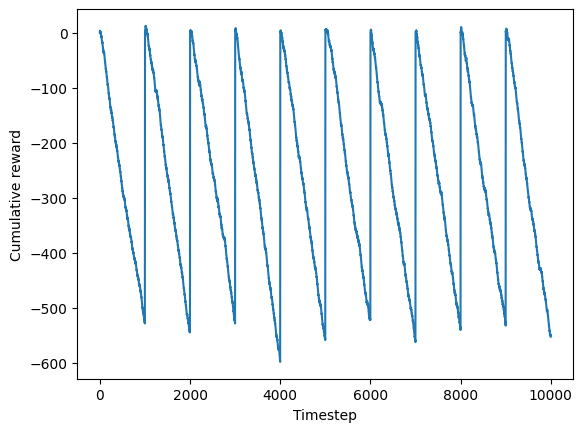

In [11]:
import matplotlib.pyplot as plt
plt.plot(cumulative_rewards)
plt.xlabel("Timestep")
plt.ylabel("Cumulative reward")

Hmmm, doesn't look great! But we haven't added a learning step yet to update the network parameters. Let's do that next.

### What about adding in the training loop?
XLRON has a super fast JAX implementation of the PPO RL algorithm (adapted from  [PureJaxRL](https://github.com/luchris429/purejaxrl)), which is easily accessed through the convenient `make_train()` function.

This will take care of the training loop, including generating parallel environments, running the agent, and updating the network parameters. The training loop is JIT-compiled to run on the CPU or GPU.


In [8]:
# Let's make a training loop, JIT-compile it to the CPU and run it!
from xlron.environments.wrappers import TimeIt
from xlron.train.ppo import make_train
import sys
from absl import flags
import xlron.train.parameter_flags
# FLAGS are commandline arguments that can be passed to the training loop
# Let's alter them in-code here
FLAGS = flags.FLAGS
FLAGS(("--env_type", "rmsa", # Type of environment to train on",
      "--k", "5",  # "Number of paths to consider for each request",
      "--topology_name",   "nsfnet", #"Name of the network topology to use",
      "--link_resources", "50",  # "Number of resources per link",
      "--max_requests", "1e3",  # "Maximum number of requests to generate",
      "--max_timesteps", "1e3",  # "Maximum number of timesteps per episode",
      "--TOTAL_TIMESTEPS", "100000",  # "Total number of timesteps to train for",
      "--incremental_loading",  # "Whether to use incremental loading (non-expiring requests)",
      "--NUM_STEPS", "50",  # "Number of steps per epoch",
      "--NUM_ENVS", "10",  # "Number of parallel environments to run",
      "--NUM_SEEDS", "1",  # "Number of seeds to run",
      "--UPDATE_EPOCHS", "10",  # "Number of epochs to train for",
      "--LR", "5e-5",  # "Learning rate",
      "--LR_SCHEDULE", "linear",  # "Learning rate schedule",
      "--VISIBLE_DEVICES", "0",  # "Visible devices",
       "--ACTION_MASKING",  # "Whether to use action masking",
       "--NUM_LAYERS", "2",  # "Number of layers in the network",
       "--NUM_UNITS", "128",  # "Number of units per layer",
      ))
# More options are available - check out the docs for more info https://micdoh.github.io/XLRON/

['--env_type', 'rmsa']

In [9]:
# NUM_ENVS determines how many parallel environments to run (with the same agent parameters for each)
with TimeIt(tag='COMPILATION'):
    train_jit = jax.jit(make_train(FLAGS), backend='cpu').lower(rng).compile()
    
print(f"Running {FLAGS.TOTAL_TIMESTEPS * FLAGS.NUM_SEEDS} timesteps on CPU")
with TimeIt(tag='EXECUTION', frames=FLAGS.TOTAL_TIMESTEPS * FLAGS.NUM_SEEDS):
    out_cpu = train_jit(rng)
    out_cpu["metrics"]["episode_returns"].block_until_ready()  # Wait for all devices to finish


COMPILATION: Elapsed time=14.37s
Running 100000.0 timesteps on CPU
EXECUTION: Elapsed time=38.36s, FPS=2.61e+03


In [10]:
# We can also parallelise across different random seeds (with different agent parameters for each)
FLAGS.NUM_ENVS = 1
FLAGS.NUM_SEEDS = 5
FLAGS.TOTAL_TIMESTEPS = 50_000
with TimeIt(tag='COMPILATION'):
    rng_seeds = jax.random.split(rng, FLAGS.NUM_SEEDS)
    train_jit = jax.jit(jax.vmap(make_train(FLAGS)), backend='cpu').lower(rng_seeds).compile()
    
print(f"Running {FLAGS.TOTAL_TIMESTEPS * FLAGS.NUM_SEEDS} timesteps on CPU")
with TimeIt(tag='EXECUTION', frames=FLAGS.TOTAL_TIMESTEPS * FLAGS.NUM_SEEDS):
    out_cpu_seeds = train_jit(rng_seeds)
    out_cpu_seeds["metrics"]["episode_returns"].block_until_ready()  # Wait for all devices to finish


COMPILATION: Elapsed time=18.50s
Running 250000 timesteps on CPU
EXECUTION: Elapsed time=232.76s, FPS=1.07e+03


___

# 5. Using the GPU &#x1f4a5;

If connected to a GPU-enabled machine, let's run the same training loop with 3000 parallel environments and see how long it takes...

In [17]:
FLAGS.NUM_SEEDS = 1
FLAGS.NUM_ENVS = 3000
FLAGS.TOTAL_TIMESTEPS = 30_000_000

with TimeIt(tag='COMPILATION'):
    train_jit = jax.jit(make_train(FLAGS), backend='gpu').lower(rng).compile()
    
print(f"Running {FLAGS.TOTAL_TIMESTEPS * FLAGS.NUM_SEEDS} timesteps on GPU")
with TimeIt(tag='EXECUTION', frames=FLAGS.TOTAL_TIMESTEPS * FLAGS.NUM_SEEDS):
    out_gpu = train_jit(rng)
    out_gpu["metrics"]["episode_returns"].block_until_ready()  # Wait for all devices to finish

COMPILATION: Elapsed time=10.72s
Running 30000000 timesteps on GPU
EXECUTION: Elapsed time=110.44s, FPS=2.72e+05


___

# 6. Evaluation and plotting &#x1f4c8;


### N.B. we haven't done any hyperparameter tuning so we shouldn't expect great results here! 

#### The main thing is the training time &#x23F0;

See the bonus section on wandb and hyperparameter sweeps to learn how to get the best hyperparameters to make your agents sing!


Text(0, 0.5, 'Cumulative return')

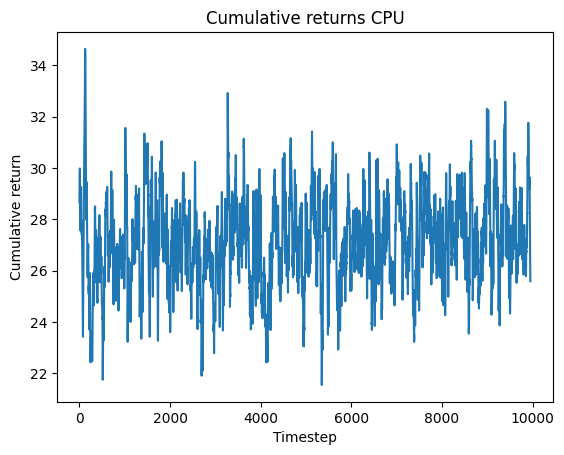

In [27]:
# Let's plot the results of the training loop
import matplotlib.pyplot as plt
import numpy as np
# Let's use a moving average to make the plots easier to read
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

cum_returns_mean_cpu = out_cpu["metrics"]["cum_returns"].mean(-1).reshape(-1)
cum_returns_mean_cpu_smooth = moving_average(cum_returns_mean_cpu, 50)
plt.plot(cum_returns_mean_cpu_smooth, label="CPU")
plt.title("Cumulative returns CPU")
plt.xlabel("Timestep")
plt.ylabel("Cumulative return")

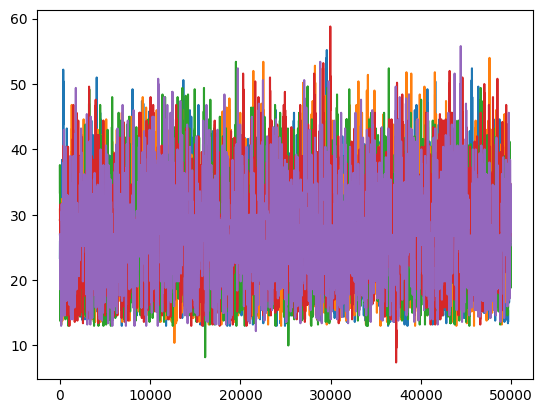

In [29]:
# Let's plot the results for our multiple seed run on CPU
for i in range(5):
    cum_returns_mean_cpu_seeds = out_cpu_seeds["metrics"]["cum_returns"][i].mean(-1).reshape(-1)
    cum_returns_mean_cpu_seeds_smooth = moving_average(cum_returns_mean_cpu_seeds, 50)
    plt.plot(cum_returns_mean_cpu_seeds_smooth, label=f"Seed {i}")

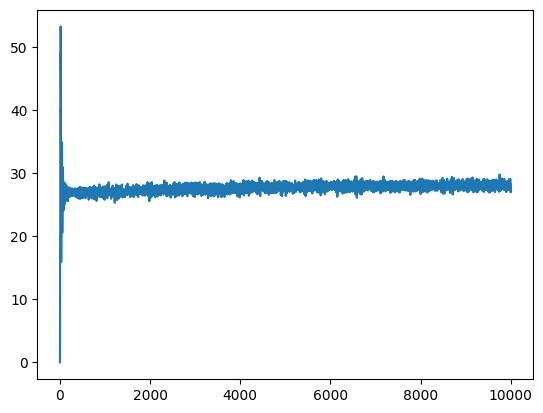

In [24]:
cum_returns_mean_gpu = out_gpu["metrics"]["cum_returns"].mean(-1).reshape(-1)
plt.plot(cum_returns_mean_gpu, label="GPU")
# The plot looks smoother because we're taking the mean of 3000 parallel environments!

Text(0, 0.5, 'Cumulative return')

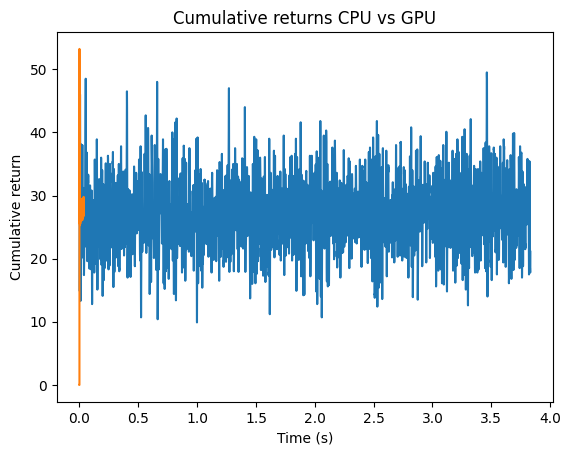

In [35]:
# Now let's rebase so that the x-axis is time and plot CPU and GPU results
# multiply by total time, divide by total number of steps
cpu_time = np.arange(len(cum_returns_mean_cpu)) * 38.36 / 1e5
gpu_time = np.arange(len(cum_returns_mean_gpu)) * 110.04 / 3e7
# let's smooth the CPU results out so we can see the plots better
cum_returns_mean_cpu_smooth = moving_average(cum_returns_mean_cpu, 10)

plt.plot(cpu_time[:len(cum_returns_mean_cpu_smooth)], cum_returns_mean_cpu_smooth, label="CPU")
plt.plot(gpu_time, cum_returns_mean_gpu, label="GPU")
plt.title("Cumulative returns CPU vs GPU")
plt.xlabel("Time (s)")
plt.ylabel("Cumulative return")

## Don't forget to check out the documentation site if you want to learn more: [https://micdoh.github.io/XLRON/](https://micdoh.github.io/XLRON/)

___

# BONUS: Experiment tracking with Weights and Biases &#x1f4d6;

In [36]:
# If you have a Weights and Biases account, you can log your experiments simply by adding the WANDB flag
! python -m xlron.train.train --env_type rmsa --k 5 --topology_name nsfnet --link_resources 50 --max_requests 1e3 --max_timesteps 1e3 --TOTAL_TIMESTEPS 30e6 --incremental_loading --NUM_STEPS 50 --NUM_ENVS 3000 --NUM_SEEDS 1 --UPDATE_EPOCHS 10 --LR 5e-5 --LR_SCHEDULE linear --VISIBLE_DEVICES 0 --ACTION_MASKING --WANDB

<frozen runpy>:128: RuntimeWarning: 'xlron.train.train' found in sys.modules after import of package 'xlron.train', but prior to execution of 'xlron.train.train'; this may result in unpredictable behaviour
CUDA_VISIBLE_DEVICES=0
Available devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]
XLA_PYTHON_CLIENT_MEM_FRACTION=0.95
XLA_PYTHON_CLIENT_PREALLOCATE=true
wandb: Currently logged in as: micdoh. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.1
wandb: Run data is saved locally in /home/uceedoh/git/XLRON/examples/wandb/run-20240324_232554-4koae966
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dark-shape-3
wandb: ⭐️ View project at https://wandb.ai/micdoh/RMSA_NSFNET_50_INC
wandb: 🚀 View run at https://wandb.ai/micdoh/RMSA_NSFNET_50_INC/runs/4koae966
logtostderr False
alsologtostderr False
log_dir 
v 0
verbosity 0
l

### Wandb is also super useful for performing hyperparameter sweeps. See wandb docs for more details: [https://docs.wandb.ai/guides/sweeps](https://docs.wandb.ai/guides/sweeps)

In [ ]:
# Setup a sweep configuration
sweep_config = {
    "method": "random",
    "metric": {"name": "cumulative_reward", "goal": "maximize"},
    "parameters": {
        "incremental_loading": {"values": [True, False]},
        "NUM_STEPS": {"values": [50, 100, 200]},
        "NUM_ENVS": {"values": [10, 100, 1000]},
        "NUM_SEEDS": {"values": [1, 5, 10]},
        "UPDATE_EPOCHS": {"values": [10, 20, 50]},
        "LR": {"values": [1e-5, 5e-5, 1e-4]},
        "LR_SCHEDULE": {"values": ["linear", "cosine", "exponential"]},
        "VISIBLE_DEVICES": {"values": [0, 1, 2, 3]},
        "ACTION_MASKING": {"values": [True]},
    },
}
# initialise a sweep
sweep_id = wandb.sweep(sweep_config, project="xlron")

In [ ]:
# run an agent with the sweep_id
!wandb agent $sweep_id